# Carregando dataset

In [1]:
import os
import numpy as np
import pydicom
from tqdm import tqdm # Ver processo do loop
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize
import pickle
from keras.preprocessing.image import ImageDataGenerator
import random
from keras import backend as K
from sklearn.model_selection import train_test_split
import shutil

seed = 42
np.random.seed(seed)

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1

DATASET_PATH = 'Sunnybrook_Dataset/SCD_DeidentifiedImages/'
CONTOUR_PATH = 'Sunnybrook_Dataset/SCD_ManualContours/'
PICKLE_PATH = 'pickle/'
AUGMENTATION_PATH = 'Sunnybrook_Dataset/Data_Augmentation/'
MODEL_PATH = 'modelo/Attention_Completa'

In [2]:
def converter_pixel_array_rgb(dicom):
    dicom_rgb = np.empty((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype=dicom.dtype)
    dicom_rgb[:,:,:] = dicom[:,:, np.newaxis]
    dicom_rgb = dicom_rgb / np.max(dicom_rgb)
    return dicom_rgb

def pre_processamento(img):
    img1=np.uint8(cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_cs = clahe.apply(img1)
    return img_cs

def converter_mascara_binario(mask):
    im_bw = mask[:,:,0]
    im_bw = im_bw[:,:,np.newaxis]
    return im_bw

In [3]:
###### ATUALIZAR BASE DA DADOS APOS DATA AUGMENTATION
def atualiza_bd(conjunto, path, tipo_conjunto):
    AUG_PATH = path + '/'
#     AUG_PATH = AUGMENTATION_PATH + tipo_conjunto + '_mask' if mascara else AUGMENTATION_PATH + tipo_conjunto
#     AUG_PATH += '/'
    
    novo_conjunto = np.empty((2*len(conjunto), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    
    cnt = 0
    print("Adicionando imagens que pertencem a base ", tipo_conjunto)
    for image in conjunto:
        novo_conjunto[cnt] = image
        cnt += 1
        
    print("Adicionando imagens do data augmentation a base ", tipo_conjunto)
    for files in os.listdir(AUG_PATH):
        arquivo = plt.imread(AUG_PATH + files)
        arquivo = converter_pixel_array_rgb(arquivo)
        novo_conjunto[cnt] = arquivo
        cnt += 1
    
    return novo_conjunto

In [4]:
###### DATA AUGMENTATION
def data_augmentation(conjunto, mascara, tipo_conjunto):
    AUG_PATH = AUGMENTATION_PATH + tipo_conjunto
    AUG_MASK_PATH = AUGMENTATION_PATH + tipo_conjunto + '_mask'
    
    shutil.rmtree(AUG_PATH)
    shutil.rmtree(AUG_MASK_PATH)
    os.mkdir(AUG_PATH)
    os.mkdir(AUG_MASK_PATH)
    
    datagen = ImageDataGenerator(rotation_range=180,
                                 zoom_range=0.5,
                                 horizontal_flip=True,
                                 vertical_flip=True
                                )
    
    print("Criando novas imagens")
    cnt_data_aug = 0
    for batch in datagen.flow(conjunto, batch_size = 1, shuffle = False, seed = seed,
                              save_to_dir = AUG_PATH, save_prefix = 'da', save_format = 'jpeg'):
        cnt_data_aug += 1
        if cnt_data_aug == len(conjunto):
            break
            
    print("Criando novos ground-truth")
    cnt_data_aug = 0
    for batch in datagen.flow(mascara, batch_size = 1, shuffle = False, seed = seed,
                              save_to_dir = AUG_MASK_PATH, save_prefix = 'da', save_format = 'jpeg'):
        cnt_data_aug += 1
        if cnt_data_aug == len(mascara):
            break
    
    conjunto = atualiza_bd(conjunto, AUG_PATH, tipo_conjunto)
    mascara = atualiza_bd(mascara, AUG_MASK_PATH, tipo_conjunto)
    
    return conjunto, mascara

In [5]:
##### contorno_pickle = array com as coordenadas do contorno
##### mascara_pickle = mascara do ground-truth
##### scans_pickle = np.array(dicom.pixel_array)

######################################################################

scans_file = PICKLE_PATH + 'scans_pickle.pickle'
contours_file = PICKLE_PATH + 'contorno_pickle.pickle'
masks_file = PICKLE_PATH + 'mascara_pickle.pickle'
with open(scans_file, 'rb') as f:
    all_scans = pickle.load(f)
    
with open(contours_file, 'rb') as f:
    all_contours = pickle.load(f)
    
with open(masks_file, 'rb') as f:
    all_masks = pickle.load(f)


all_scans = list(map(pre_processamento, all_scans))
all_scans = list(map(converter_pixel_array_rgb, all_scans))
all_scans = np.array(all_scans)

all_masks = list(map(converter_mascara_binario, all_masks))
all_masks = np.array(all_masks)

# Separar em treino, teste e validacao
X_train, X_test, Y_train, Y_test = train_test_split(all_scans, all_masks, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.125, random_state=1)


print("Total de imagens: ", len(X_train) + len(X_test) + len(X_val), " treino: ", len(X_train), " val: ", len(X_val))
# Fazer Data augmentation
X_train, Y_train = data_augmentation(X_train, Y_train, 'train')
X_val, Y_val = data_augmentation(X_val, Y_val, 'val')


# # converter para float
# X_train = X_train / 255
# X_val = X_val / 255
# X_test = X_test / 255

Y_train = np.where(Y_train>128, 1.0, 0.0)
Y_val = np.where(Y_val>128, 1.0, 0.0)
Y_test = np.where(Y_test>128, 1.0, 0.0)

Total de imagens:  805  treino:  563  val:  81
Criando novas imagens
Criando novos ground-truth
Adicionando imagens que pertencem a base  train
Adicionando imagens do data augmentation a base  train
Adicionando imagens que pertencem a base  train
Adicionando imagens do data augmentation a base  train
Criando novas imagens
Criando novos ground-truth
Adicionando imagens que pertencem a base  val
Adicionando imagens do data augmentation a base  val
Adicionando imagens que pertencem a base  val
Adicionando imagens do data augmentation a base  val


In [6]:
len(X_train), len(X_test), len(X_val)

(1126, 161, 162)

In [7]:
Y_train.shape

(1126, 256, 256, 1)

In [8]:
len(X_train)

1126

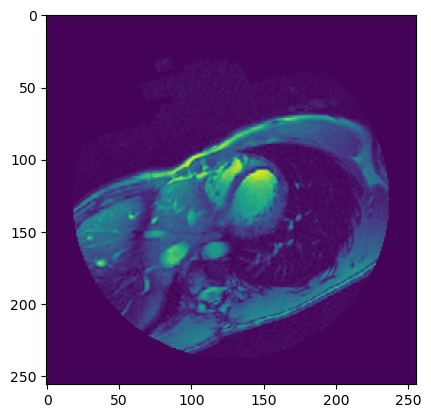

In [9]:
# print(Y_train[0][0])
plt.imshow(X_train[0])
plt.show()

In [10]:
kwargs = dict(
        rotation_range=180,
        zoom_range=0.0,
        width_shift_range=0.0,
        height_shift_range=0.0,
        horizontal_flip=True,
        vertical_flip=True
    )

X_datagen = ImageDataGenerator(**kwargs)
Y_datagen = ImageDataGenerator(**kwargs)
val_X_datagen = ImageDataGenerator(**kwargs)
val_Y_datagen = ImageDataGenerator(**kwargs)


X_generator = X_datagen.flow(X_train, shuffle=False,
                                    batch_size=10, seed=seed)
Y_generator = Y_datagen.flow(Y_train, shuffle=False,
                                batch_size=10, seed=seed)
train_generator = zip(X_generator, Y_generator)

val_X_generator = val_X_datagen.flow(X_val, shuffle=False,
                                    batch_size=10, seed=seed)
val_Y_generator = val_Y_datagen.flow(Y_val, shuffle=False,
                                batch_size=10, seed=seed)
val_generator = zip(val_X_generator, val_Y_generator)

# Metricas

In [11]:
def dice_coef(y_true, y_pred, smooth=1.0):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = K.mean((2.0 * intersection + smooth)/(union + smooth))
    return dice

def dice_loss(smooth):
    def dice(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
    return dice

def dice_mon(smooth):
    def dicemon(y_true, y_pred):
        return dice_coef(y_true, y_pred, smooth=smooth)
    return dicemon

def jaccard_coef(y_true, y_pred, smooth=0.0):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    jaccard = K.mean((intersection + smooth) / (union + smooth), axis = 0)
    return jaccard

def jaccard_mon(smooth):
    def jaccardmon(y_true, y_pred):
        return jaccard_coef(y_true, y_pred, smooth=smooth)
    return jaccardmon

# Modelando Unet

In [12]:
import tensorflow as tf
from keras.models import *
from keras.layers import *

tf.random.set_seed(seed)

In [13]:
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    
    # getting x to the same shape as the gating signal
    theta_x = Conv2D(inter_shape,(2,2), strides=(2,2), padding='same')(x)
    shape_theta_x = K.int_shape(theta_x)
    
    # getting the gating signal to the same nunmber of filters as the inter_shape
    phi_g = Conv2D(inter_shape, (1,1), padding='same')(gating)
    
    upsample_g = Conv2DTranspose(inter_shape, (3,3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), padding='same')(phi_g)
    
    concat_xg = add([upsample_g, theta_x])
    
    act_xg = Activation('relu')(concat_xg)
    
    psi = Conv2D(1, (1,1), padding='same')(act_xg)
    
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    
    upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    
    y = multiply([upsample_psi, x])
    
    result = Conv2D(shape_x[3], (1,1), padding='same')(y)
    result_bn = BatchNormalization()(result)
    
    return result_bn

In [14]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2,2))(c1)

c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2,2))(c2)

c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2,2))(c3)

c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D((2,2))(c4)

c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2D(512, (1, 1), padding='same')(c5)
u6 = Activation('relu')(u6)
u6 = attention_block(c4, u6, 512)
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Conv2D(512, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = Conv2D(512, (1, 1), padding='same')(c6)
u7 = Activation('relu')(u7)
u7 = attention_block(c3, u7, 256)
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Conv2D(256, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = Conv2D(512, (1, 1), padding='same')(c7)
u8 = Activation('relu')(u8)
u8 = attention_block(c2, u8, 128)
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Conv2D(128, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = Conv2D(512, (1, 1), padding='same')(c8)
u9 = Activation('relu')(u9)
u9 = attention_block(c1, u9, 64)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Conv2D(64, 3, activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = Conv2D(1, 1, activation='sigmoid')(c9)
 
model = Model(inputs=[inputs], outputs=[outputs])

# Configurando as metricas
smooth = K.epsilon()
dice_model = dice_loss(smooth)
dicemon = dice_mon(smooth)
jaccardmon = jaccard_mon(smooth)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])
# model.compile(optimizer = 'adam', loss = dice_model, metrics = [dicemon, 'accuracy', jaccardmon])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('logs/model_attention_completo.h5', verbose=1, save_weights_only=True)

callbacks = [checkpoint,
#         tf.keras.callbacks.EarlyStopping(patience=20, monitor='val_dicemon'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]



In [16]:
# results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=2, epochs=25, callbacks=callbacks)
results = model.fit(train_generator,steps_per_epoch=len(X_train)/10,epochs=200,
                    callbacks=callbacks, validation_data=val_generator, validation_steps=len(X_val)/10)
json_model = model.to_json()
open(MODEL_PATH + '.json', 'w').write(json_model)
model.save_weights(MODEL_PATH + '.h5', overwrite=True)

C:\Users\Margeo\anaconda3\envs\TCC\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/200
112/112 [==============================] - 104s 616ms/step - loss: 0.1213 - accuracy: 0.9680 - dicemon: 0.0445 - jaccardmon: 0.0216 - val_loss: 0.1363 - val_accuracy: 0.9904 - val_dicemon: 7.2340e-04 - val_jaccardmon: 3.8581e-04

Epoch 00001: saving model to logs\model_attention_completo.h5
Epoch 2/200
112/112 [==============================] - 61s 543ms/step - loss: 0.0984 - accuracy: 0.9848 - dicemon: 0.0449 - jaccardmon: 0.0213 - val_loss: 0.2520 - val_accuracy: 0.9904 - val_dicemon: 8.1075e-06 - val_jaccardmon: 5.4113e-06

Epoch 00002: saving model to logs\model_attention_completo.h5
Epoch 3/200
112/112 [==============================] - 61s 545ms/step - loss: 0.1075 - accuracy: 0.9849 - dicemon: 0.0449 - jaccardmon: 0.0214 - val_loss: 0.3643 - val_accuracy: 0.9904 - val_dicemon: 1.8990e-07 - val_jaccardmon: 2.3600e-07

Epoch 00003: saving model to logs\model_attention_completo.h5
Epoch 4/200
112/112 [==============================] - 62s 547ms/step - loss: 0.1122 - acc

112/112 [==============================] - 61s 544ms/step - loss: 0.0687 - accuracy: 0.9849 - dicemon: 0.0505 - jaccardmon: 0.0244 - val_loss: 0.0748 - val_accuracy: 0.9904 - val_dicemon: 9.9523e-04 - val_jaccardmon: 4.4274e-04

Epoch 00028: saving model to logs\model_attention_completo.h5
Epoch 29/200
112/112 [==============================] - 61s 545ms/step - loss: 0.0696 - accuracy: 0.9849 - dicemon: 0.0503 - jaccardmon: 0.0244 - val_loss: 0.0823 - val_accuracy: 0.9904 - val_dicemon: 0.0015 - val_jaccardmon: 5.5928e-04

Epoch 00029: saving model to logs\model_attention_completo.h5
Epoch 30/200
112/112 [==============================] - 61s 543ms/step - loss: 0.0688 - accuracy: 0.9849 - dicemon: 0.0478 - jaccardmon: 0.0230 - val_loss: 0.0689 - val_accuracy: 0.9904 - val_dicemon: 0.0019 - val_jaccardmon: 7.9735e-04

Epoch 00030: saving model to logs\model_attention_completo.h5
Epoch 31/200
112/112 [==============================] - 61s 545ms/step - loss: 0.0681 - accuracy: 0.9849 - di

112/112 [==============================] - 61s 543ms/step - loss: 0.0638 - accuracy: 0.9848 - dicemon: 0.0494 - jaccardmon: 0.0235 - val_loss: 0.0643 - val_accuracy: 0.9904 - val_dicemon: 0.0045 - val_jaccardmon: 0.0019

Epoch 00055: saving model to logs\model_attention_completo.h5
Epoch 56/200
112/112 [==============================] - 61s 546ms/step - loss: 0.0643 - accuracy: 0.9849 - dicemon: 0.0494 - jaccardmon: 0.0237 - val_loss: 0.0911 - val_accuracy: 0.9904 - val_dicemon: 6.2385e-04 - val_jaccardmon: 2.2190e-04

Epoch 00056: saving model to logs\model_attention_completo.h5
Epoch 57/200
112/112 [==============================] - 61s 545ms/step - loss: 0.0708 - accuracy: 0.9848 - dicemon: 0.0538 - jaccardmon: 0.0261 - val_loss: 0.1172 - val_accuracy: 0.9904 - val_dicemon: 2.9637e-04 - val_jaccardmon: 1.6256e-04

Epoch 00057: saving model to logs\model_attention_completo.h5
Epoch 58/200
112/112 [==============================] - 61s 543ms/step - loss: 0.0749 - accuracy: 0.9849 - di

112/112 [==============================] - 61s 546ms/step - loss: 0.0473 - accuracy: 0.9848 - dicemon: 0.1153 - jaccardmon: 0.0564 - val_loss: 0.0751 - val_accuracy: 0.9904 - val_dicemon: 5.3078e-04 - val_jaccardmon: 2.8172e-04

Epoch 00082: saving model to logs\model_attention_completo.h5
Epoch 83/200
112/112 [==============================] - 62s 547ms/step - loss: 0.0472 - accuracy: 0.9849 - dicemon: 0.1164 - jaccardmon: 0.0571 - val_loss: 0.0746 - val_accuracy: 0.9904 - val_dicemon: 5.2972e-04 - val_jaccardmon: 2.7424e-04

Epoch 00083: saving model to logs\model_attention_completo.h5
Epoch 84/200
112/112 [==============================] - 61s 546ms/step - loss: 0.0468 - accuracy: 0.9849 - dicemon: 0.1204 - jaccardmon: 0.0592 - val_loss: 0.0747 - val_accuracy: 0.9904 - val_dicemon: 5.1838e-04 - val_jaccardmon: 2.5163e-04

Epoch 00084: saving model to logs\model_attention_completo.h5
Epoch 85/200
112/112 [==============================] - 61s 545ms/step - loss: 0.0470 - accuracy: 0.9

Epoch 109/200
112/112 [==============================] - 61s 546ms/step - loss: 0.0440 - accuracy: 0.9850 - dicemon: 0.1534 - jaccardmon: 0.0771 - val_loss: 0.0777 - val_accuracy: 0.9904 - val_dicemon: 5.2968e-04 - val_jaccardmon: 2.9771e-04

Epoch 00109: saving model to logs\model_attention_completo.h5
Epoch 110/200
112/112 [==============================] - 62s 547ms/step - loss: 0.0441 - accuracy: 0.9850 - dicemon: 0.1516 - jaccardmon: 0.0760 - val_loss: 0.0786 - val_accuracy: 0.9904 - val_dicemon: 4.4919e-04 - val_jaccardmon: 2.4823e-04

Epoch 00110: saving model to logs\model_attention_completo.h5
Epoch 111/200
112/112 [==============================] - 62s 548ms/step - loss: 0.0439 - accuracy: 0.9850 - dicemon: 0.1518 - jaccardmon: 0.0764 - val_loss: 0.0822 - val_accuracy: 0.9904 - val_dicemon: 3.2259e-04 - val_jaccardmon: 1.7425e-04

Epoch 00111: saving model to logs\model_attention_completo.h5
Epoch 112/200
112/112 [==============================] - 61s 545ms/step - loss: 0.044

Epoch 136/200
112/112 [==============================] - 61s 543ms/step - loss: 0.0428 - accuracy: 0.9850 - dicemon: 0.1679 - jaccardmon: 0.0854 - val_loss: 0.0777 - val_accuracy: 0.9904 - val_dicemon: 5.2511e-04 - val_jaccardmon: 2.8053e-04

Epoch 00136: saving model to logs\model_attention_completo.h5
Epoch 137/200
112/112 [==============================] - 61s 542ms/step - loss: 0.0424 - accuracy: 0.9850 - dicemon: 0.1708 - jaccardmon: 0.0868 - val_loss: 0.0790 - val_accuracy: 0.9904 - val_dicemon: 4.2243e-04 - val_jaccardmon: 2.2193e-04

Epoch 00137: saving model to logs\model_attention_completo.h5
Epoch 138/200
112/112 [==============================] - 61s 544ms/step - loss: 0.0420 - accuracy: 0.9851 - dicemon: 0.1733 - jaccardmon: 0.0882 - val_loss: 0.0874 - val_accuracy: 0.9904 - val_dicemon: 2.3584e-04 - val_jaccardmon: 1.3022e-04

Epoch 00138: saving model to logs\model_attention_completo.h5
Epoch 139/200
112/112 [==============================] - 61s 546ms/step - loss: 0.042

Epoch 163/200
112/112 [==============================] - 61s 544ms/step - loss: 0.0411 - accuracy: 0.9852 - dicemon: 0.1844 - jaccardmon: 0.0946 - val_loss: 0.0793 - val_accuracy: 0.9904 - val_dicemon: 4.8240e-04 - val_jaccardmon: 2.5020e-04

Epoch 00163: saving model to logs\model_attention_completo.h5
Epoch 164/200
112/112 [==============================] - 61s 545ms/step - loss: 0.0414 - accuracy: 0.9852 - dicemon: 0.1821 - jaccardmon: 0.0932 - val_loss: 0.0824 - val_accuracy: 0.9904 - val_dicemon: 4.3033e-04 - val_jaccardmon: 2.3874e-04

Epoch 00164: saving model to logs\model_attention_completo.h5
Epoch 165/200
112/112 [==============================] - 61s 545ms/step - loss: 0.0409 - accuracy: 0.9852 - dicemon: 0.1868 - jaccardmon: 0.0958 - val_loss: 0.0838 - val_accuracy: 0.9904 - val_dicemon: 3.1752e-04 - val_jaccardmon: 1.7606e-04

Epoch 00165: saving model to logs\model_attention_completo.h5
Epoch 166/200
112/112 [==============================] - 61s 545ms/step - loss: 0.041

Epoch 190/200
112/112 [==============================] - 61s 546ms/step - loss: 0.0407 - accuracy: 0.9852 - dicemon: 0.1918 - jaccardmon: 0.0987 - val_loss: 0.0861 - val_accuracy: 0.9904 - val_dicemon: 3.2878e-04 - val_jaccardmon: 1.7469e-04

Epoch 00190: saving model to logs\model_attention_completo.h5
Epoch 191/200
112/112 [==============================] - 62s 547ms/step - loss: 0.0407 - accuracy: 0.9852 - dicemon: 0.1910 - jaccardmon: 0.0984 - val_loss: 0.0852 - val_accuracy: 0.9904 - val_dicemon: 4.5869e-04 - val_jaccardmon: 2.2474e-04

Epoch 00191: saving model to logs\model_attention_completo.h5
Epoch 192/200
112/112 [==============================] - 62s 547ms/step - loss: 0.0405 - accuracy: 0.9852 - dicemon: 0.1926 - jaccardmon: 0.0994 - val_loss: 0.0803 - val_accuracy: 0.9904 - val_dicemon: 5.6286e-04 - val_jaccardmon: 2.9324e-04

Epoch 00192: saving model to logs\model_attention_completo.h5
Epoch 193/200
112/112 [==============================] - 62s 547ms/step - loss: 0.040

In [ ]:
# Carregar modelo
model = model_from_json(open(MODEL_PATH + '.json').read())
model.load_weights(MODEL_PATH + '.h5')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', dicemon, jaccardmon])

In [17]:
print(results.history.keys())
model.evaluate(X_train, Y_train)

dict_keys(['loss', 'accuracy', 'dicemon', 'jaccardmon', 'val_loss', 'val_accuracy', 'val_dicemon', 'val_jaccardmon'])
36/36 [==============================] - 26s 392ms/step - loss: 0.0836 - accuracy: 0.9915 - dicemon: 2.6159e-04 - jaccardmon: 1.5911e-04


[0.08360913395881653,
 0.9914823770523071,
 0.0002615891571622342,
 0.00015910560614429414]

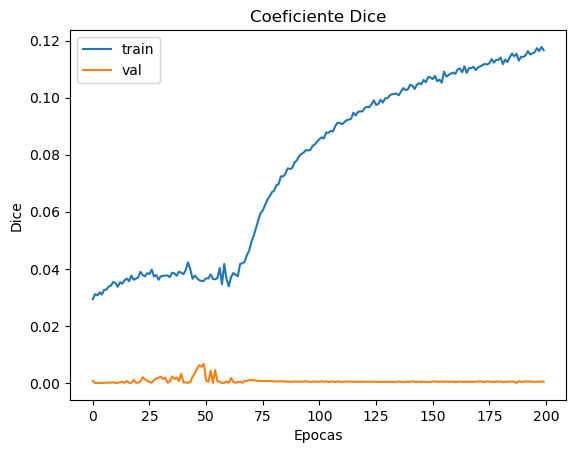

In [18]:
plt.plot(results.history['dicemon'])
plt.plot(results.history['val_dicemon'])
plt.title('Coeficiente Dice')

plt.ylabel('Dice')
plt.xlabel('Epocas')
# plt.axis([0, 100, 0, 1])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

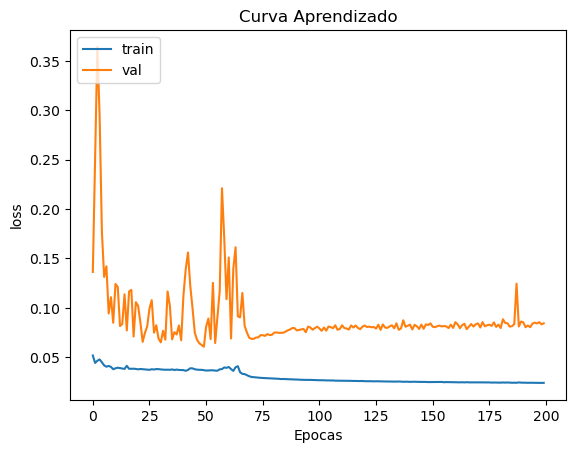

In [21]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Curva Aprendizado')

plt.ylabel('loss')
plt.xlabel('Epocas')
# plt.axis([0, 100, 0, 1])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
predict_test = model.predict(X_test, verbose=1)

6/6 [==============================] - 5s 451ms/step


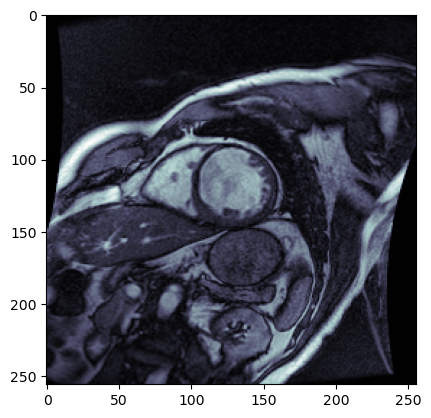

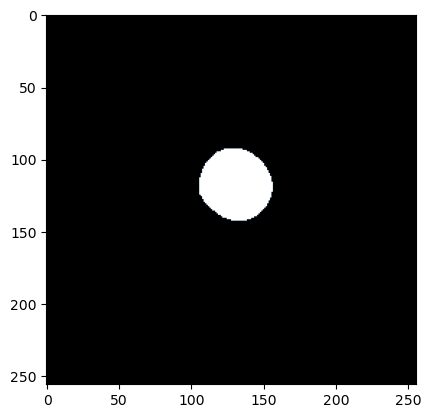

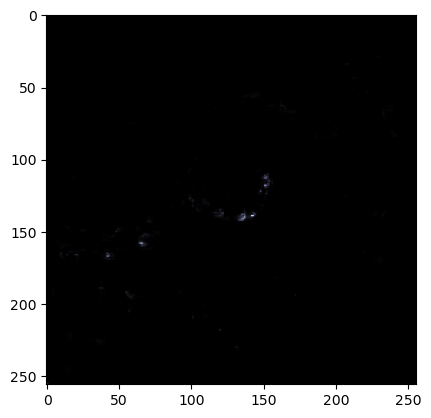

In [23]:
# Ver exemplos de imagens
exemplo = 27

plt.imshow(X_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[exemplo], cmap=plt.cm.bone)
plt.show()
plt.imshow(predict_test[exemplo], cmap=plt.cm.bone)
plt.show()

In [ ]:
from skimage import img_as_ubyte 

def add_mascara(imagem, mascara, cor):
    img = imagem.copy()
    if np.ndim(img) == 2:
        img2 = np.empty((256, 256, 3), dtype=img.dtype)
        img2[:,:,:] = img[:,:, np.newaxis]
        img = img2
    
    mask = mascara.copy()
    if np.ndim(mask) == 3:
#         mask = cv2.cvtColor(mask.astype('uint8') * 255, cv2.COLOR_BGR2GRAY)
#         ret, bw_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        bw_mask = mask
    else:
        bw_mask = img_as_ubyte(mask)
        
    contours, _ = cv2.findContours(bw_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        ctrs = [len(ctr) for ctr in contours]
        max_ctr = np.argmax(ctrs)
        pontos = np.array([pt[0] for pt in contours[max_ctr]])
        cv2.drawContours(img, np.array([pontos]),  0, cor, 1)

    return img
    

def marcar_ground_truth(ind, imagem, mascara):
    img1 = imagem[ind]
    img1 = np.squeeze(img1)
    img2 = mascara[ind]   
    img3 = add_mascara(img1, img2, (0, 255, 0))
    
    return img3

def marcar_predict(ind, imagem, mascara):
    img1 = imagem
    img2 = np.squeeze(mascara[ind])
    img3 = add_mascara(img1, img2, (255, 0, 0))
    return img3

dicom = X_test[exemplo]
mascara_gt = Y_test[exemplo]
mascara_p = predict_test[exemplo]

dicom2 = marcar_ground_truth(exemplo, X_test, Y_test)
dicom2 = marcar_predict(exemplo, dicom2, predict_test)
plt.imshow(dicom2)
plt.show()

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
plt.imshow(X_train[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_train[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(X_test[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_test[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(X_val[0], cmap=plt.cm.bone)
plt.show()
plt.imshow(Y_val[0], cmap=plt.cm.bone)
plt.show()